<a href="https://colab.research.google.com/github/gohzhihwee/stuffs/blob/main/transformer_findata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import math
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [2]:
def create_sequences(data, time_steps):
    X, y = [], []
    for x in range(len(data)-time_steps):
      X.append(data.iloc[x:x+time_steps].values)
      y.append([data.iloc[x+time_steps].values])
    return X, y

In [3]:
time_steps = 100
training_dataset = pd.read_csv("HKEX-06669.csv")
testing_dataset = pd.read_csv("HKEX-10276.csv")
testing_data = testing_dataset.iloc[:, [1,4,5,7,8,9,10,11]]
training_data = training_dataset.iloc[:len(testing_data), [1,4,5,7,8,9,10,11]]

def min_max_scaler(data):
    for col in data.columns:
      data[f'{col}'] = data[f'{col}']/data[f'{col}'].abs().max()
      data[f'{col}'] = data[f'{col}'].fillna(0)
    return data

training_data = min_max_scaler(training_data)
testing_data = min_max_scaler(testing_data)

print(training_data)
print(testing_data)


X_train, y_train = create_sequences(training_data, time_steps)
X_test, y_test = create_sequences(testing_data, time_steps)

X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)



     Nominal Price       Bid       Ask      High       Low  Previous Close  \
0         0.578362  0.578362  0.579053  0.578471  0.590526        0.577351   
1         0.577351  0.567240  0.575025  0.595573  0.591579        0.576340   
2         0.576340  0.566229  0.574018  0.582495  0.586316        0.570273   
3         0.570273  0.567240  0.568983  0.583501  0.589474        0.574317   
4         0.574317  0.566229  0.575025  0.578471  0.589474        0.561173   
..             ...       ...       ...       ...       ...             ...   
134       0.866532  0.864510  0.864048  0.867203  0.895789        0.868554   
135       0.868554  0.867543  0.865055  0.867203  0.894737        0.871587   
136       0.871587  0.868554  0.869084  0.875252  0.903158        0.874621   
137       0.874621  0.873610  0.871098  0.879276  0.907368        0.876643   
138       0.876643  0.876643  0.874119  0.884306  0.903158        0.879676   

     Share Volume (000)  Turnover (000)  
0              0.0251

<ipython-input-3-2eeafd6dd330>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}'] = data[f'{col}']/data[f'{col}'].abs().max()
<ipython-input-3-2eeafd6dd330>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}'] = data[f'{col}'].fillna(0)


In [4]:
## Implementation taken from Theodoros Ntakouris (can be found on the Keras website)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def transformer_decoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x, use_causal_mask=True)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x_int = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        x_f = transformer_decoder(x_int, head_size, num_heads, ff_dim, dropout)

    outputs = x_f
    return keras.Model(inputs, outputs)

def build_model_y(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x_int = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        x_f = transformer_decoder(x_int, head_size, num_heads, ff_dim, dropout)
    x_f = layers.Flatten()(x_f)
    outputs = layers.Dense(n_classes, activation="linear")(x_f)
    return keras.Model(inputs, outputs)

In [6]:
input_shape = X_train.shape[1:]
n_classes = X_train.shape[2]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_y = build_model_y(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=8,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

mse = keras.losses.MeanSquaredError()

model.compile(
    loss=mse,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
model.summary()

model_y.compile(
    loss=mse,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
model_y.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)]

history = model.fit(
    X_train,
    X_train,
    validation_split=0.25,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

history_y = model_y.fit(
    X_train,
    y_train,
    validation_split=0.25,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test, X_test, verbose=1)
model_y.evaluate(X_test, y_test, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 8)]     0           []                               
                                                                                                  
 layer_normalization_28 (LayerN  (None, 100, 8)      16          ['input_1[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_21 (Multi  (None, 100, 8)      35848       ['layer_normalization_28[0][0]', 
 HeadAttention)                                                   'layer_normalization_28[0][0]'] 
                                                                                              

[0.18829983472824097, 0.15245495736598969]

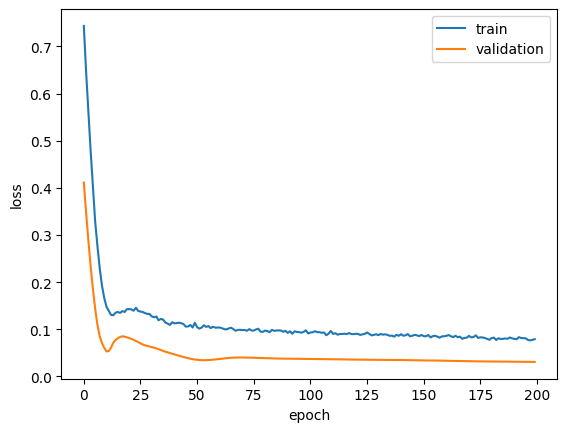

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

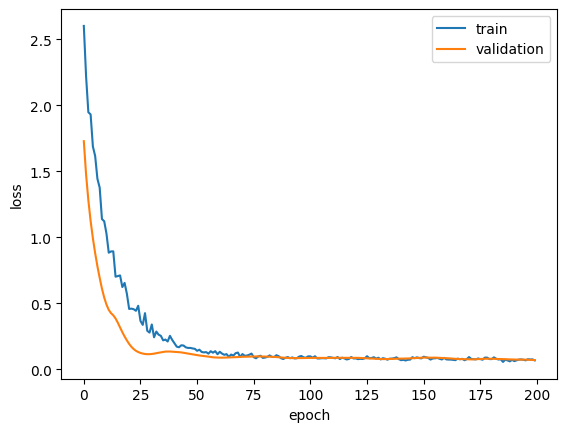

In [8]:
plt.plot(history_y.history['loss'])
plt.plot(history_y.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [9]:
import pickle as pkl
pkl.dump(model, open("trans_findata.pkl", "wb"))
pkl.dump(model_y, open("trans_findata_y.pkl", "wb"))

In [10]:
import joblib
test_model = joblib.load("trans_findata.pkl")
test_model_y = joblib.load("trans_findata_y.pkl")
X_test_pred = test_model.predict(X_test)
y_test_pred = test_model_y.predict(X_test)

2/2 [==============================] - 1s 90ms/step


In [11]:
print(len(X_test))
print(len(X_test_pred))

39
39


In [12]:
def pred_sequence(predicted_data, predicted_data_y):
    pred_list = []
    for i in range(len(predicted_data[0])):
      pred_list.append(predicted_data[0][i]) #Only the first 100(=time_steps) data points are autoencoded - the rest are projected
    for j in range(len(predicted_data_y)):
      pred_list.append(predicted_data_y[j])
    pred = np.array(pred_list)
    return pred

pred_testing_data = pd.DataFrame(pred_sequence(X_test_pred, y_test_pred), columns=testing_data.columns)
print(pred_testing_data)

     Nominal Price       Bid       Ask      High       Low  Previous Close  \
0         0.795164  0.920186  0.835874  0.892599  0.595101        0.607498   
1         0.369618  0.651461  0.793404  0.837576  0.488234        0.673638   
2         0.186154  0.570556  0.657211  0.694735  0.476007        0.906456   
3         0.672262  0.897645  1.084290  0.994169  0.559413        0.966165   
4         1.107377  1.155049  0.883295  0.934570  0.658608        0.594022   
..             ...       ...       ...       ...       ...             ...   
134       0.343179  0.113417  0.134487  0.518343  0.585368        1.354383   
135      -0.301059 -0.533238  0.656012  0.217308 -0.114949        0.418579   
136      -0.035706  0.130791  0.148050  0.229466  0.623625        0.610347   
137       0.162516 -0.043975  0.524642  0.505802  0.077026        0.618453   
138      -0.491721 -0.423410  0.564515  0.399889  0.461242        0.655538   

     Share Volume (000)  Turnover (000)  
0              0.1433

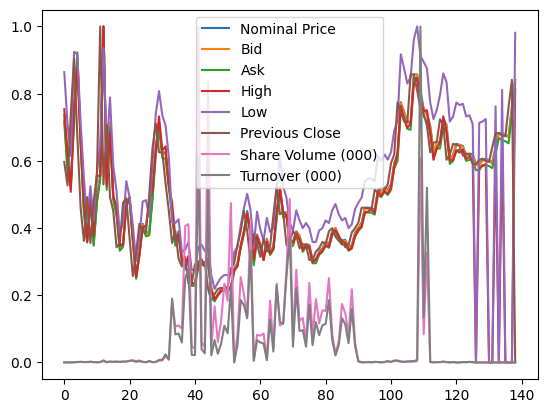

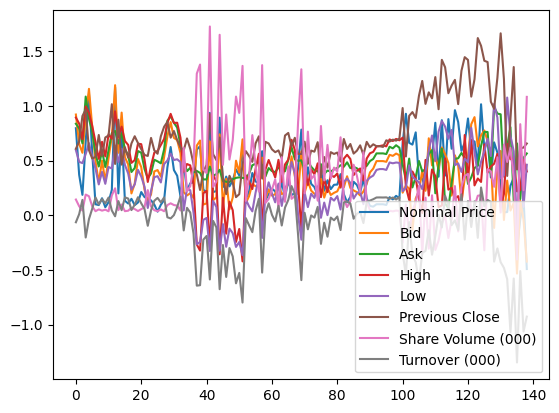

In [13]:
testing_data.plot()
pred_testing_data.plot()
plt.show()

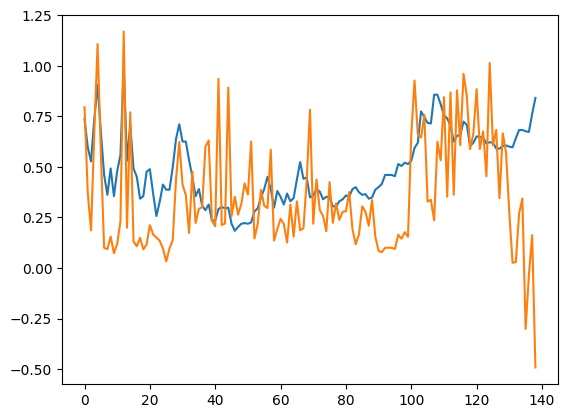

In [14]:
testing_data['Nominal Price'].plot()
pred_testing_data['Nominal Price'].plot()
plt.show()

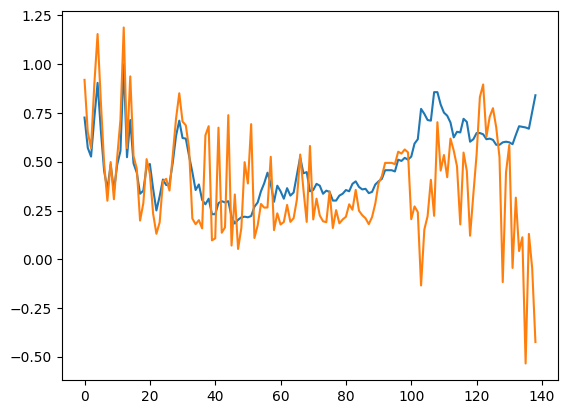

In [15]:
testing_data['Bid'].plot()
pred_testing_data['Bid'].plot()
plt.show()

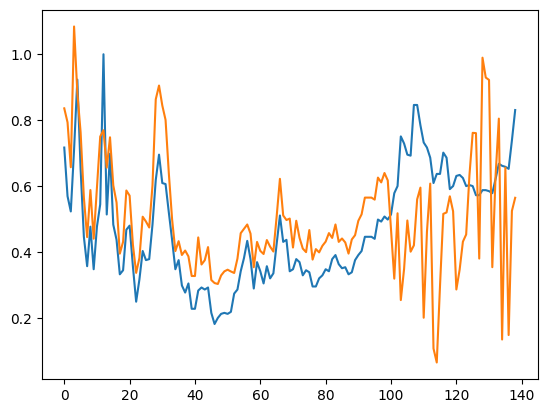

In [16]:
testing_data['Ask'].plot()
pred_testing_data['Ask'].plot()
plt.show()

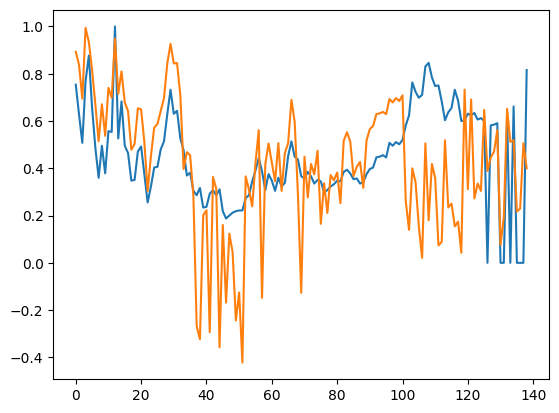

In [17]:
testing_data['High'].plot()
pred_testing_data['High'].plot()
plt.show()

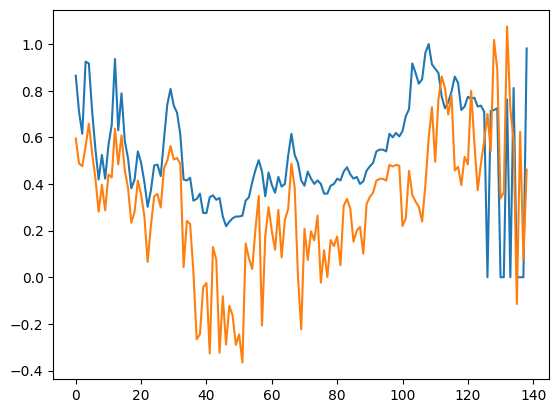

In [18]:
testing_data['Low'].plot()
pred_testing_data['Low'].plot()
plt.show()

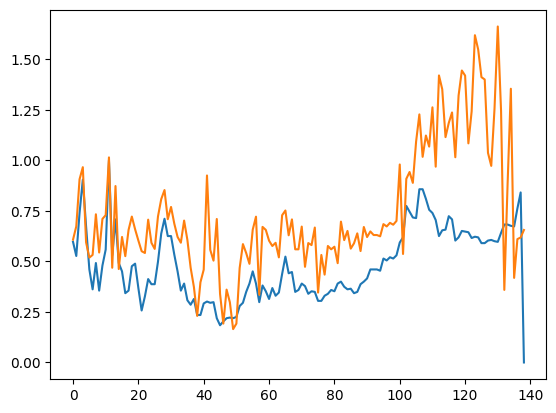

In [19]:
testing_data['Previous Close'].plot()
pred_testing_data['Previous Close'].plot()
plt.show()

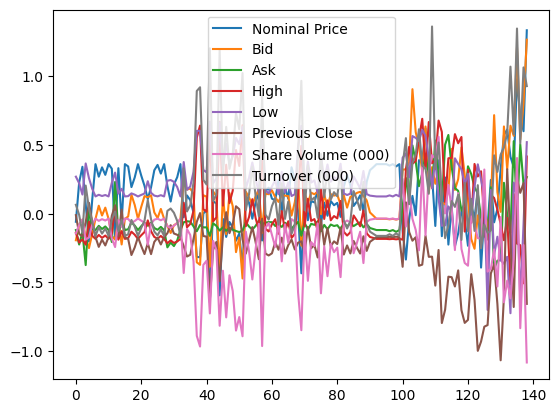

In [20]:
delta_data = testing_data - pred_testing_data #Convention is actual - predicted
delta_data.plot()
plt.show()

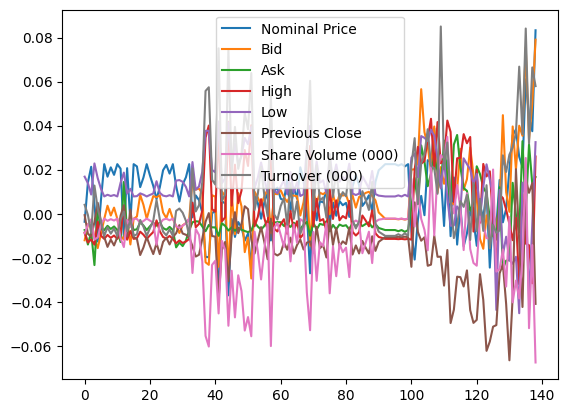

In [21]:
aggr_data = testing_data + pred_testing_data
avg_data = aggr_data.div(2)
#Using 1 s.d. as the numerical threshold
while delta_data.abs().max().max() >= 0.15:
  aggr_data = testing_data + avg_data
  avg_data = aggr_data.div(2)
  delta_data = testing_data - avg_data
delta_data.plot()
plt.show()

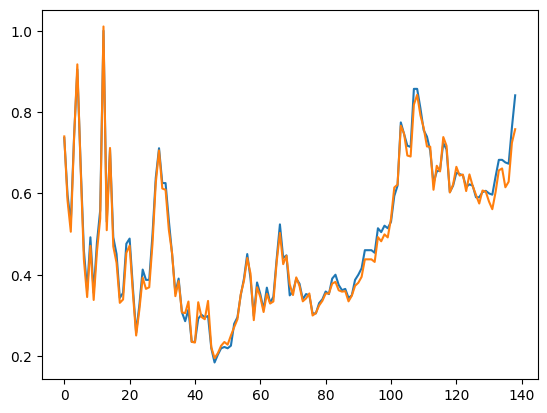

In [22]:
testing_data['Nominal Price'].plot()
avg_data['Nominal Price'].plot()
plt.show()

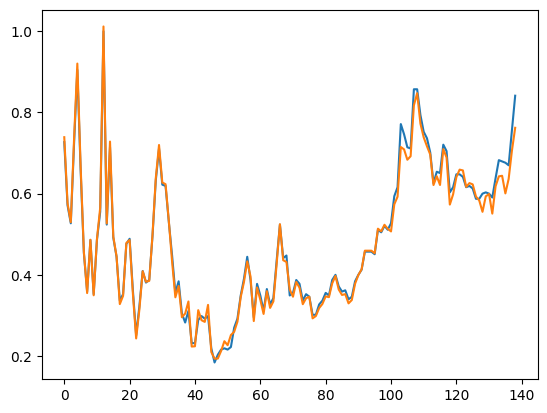

In [23]:
testing_data['Bid'].plot()
avg_data['Bid'].plot()
plt.show()

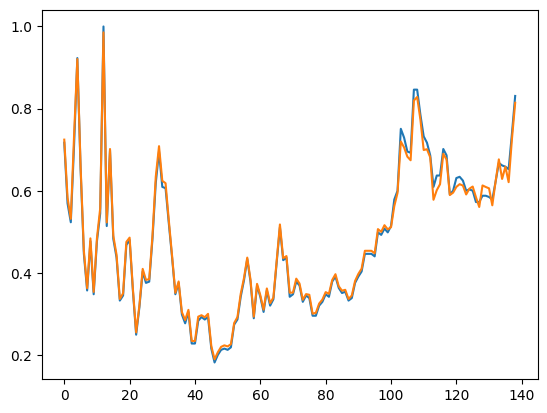

In [24]:
testing_data['Ask'].plot()
avg_data['Ask'].plot()
plt.show()

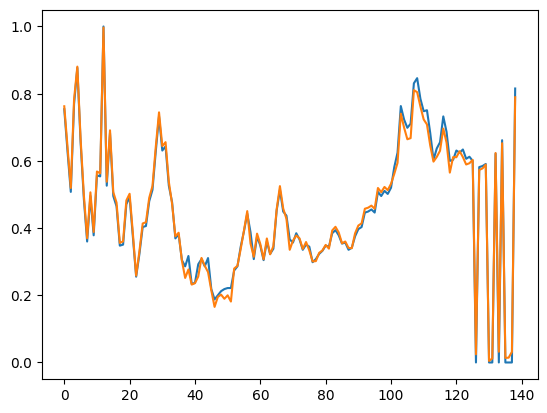

In [25]:
testing_data['High'].plot()
avg_data['High'].plot()
plt.show()

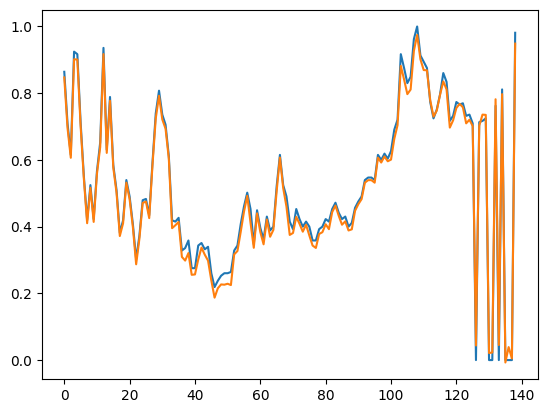

In [26]:
testing_data['Low'].plot()
avg_data['Low'].plot()
plt.show()

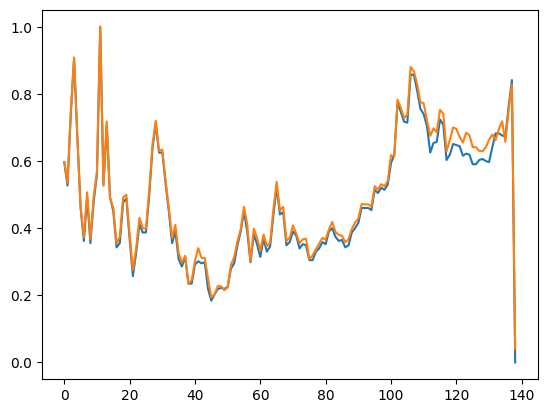

In [27]:
testing_data['Previous Close'].plot()
avg_data['Previous Close'].plot()
plt.show()

In [28]:
#Assume that no action was taken at t=0
testing_data_str = testing_data['Nominal Price'].to_numpy()
avg_data_str = avg_data['Nominal Price'].to_numpy()
price_str, buy_price, sell_price = [], [], []
ticker = 0
for i in range(len(testing_data_str)-1):
  if i == 0:
    price_str.append(testing_data_str[0])
  else:
    if np.sign(testing_data_str[i+1] - testing_data_str[i]) == np.sign(avg_data_str[i+1] - avg_data_str[i]):
      price_str.append(avg_data_str[i])
    else:
      price_str.append(testing_data_str[i])
  ticker += 1
  if ticker== time_steps or i+1 == len(testing_data_str):
    if price_str[ticker-1] < price_str[0]:
      print(f"Buy action taken - instrument was purchased at {price_str[ticker-1]}")
      buy_price.append(price_str[ticker-1])
    else:
      if len(buy_price) == 0 or (len(buy_price) == len(sell_price)+1 and max(buy_price) >= price_str[ticker-1]):
        print("No action taken")
      else:
        print(f"Sell action taken - instrument was sold at {price_str[ticker-1]}")
        sell_price.append(price_str[ticker-1])
    ticker = 0
    price_str = []

print(buy_price)
print(sell_price)


1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
39
39
40
40
41
41
42
42
43
43
44
44
45
45
46
46
47
47
48
48
49
49
50
50
51
51
52
52
53
53
54
54
55
55
56
56
57
57
58
58
59
59
60
60
61
61
62
62
63
63
64
64
65
65
66
66
67
67
68
68
69
69
70
70
71
71
72
72
73
73
74
74
75
75
76
76
77
77
78
78
79
79
80
80
81
81
82
82
83
83
84
84
85
85
86
86
87
87
88
88
89
89
90
90
91
91
92
92
93
93
94
94
95
95
96
96
97
97
98
98
99
99
100
100
Buy action taken - instrument was purchased at 0.49178397362785686
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20
21
21
22
22
23
23
24
24
25
25
26
26
27
27
28
28
29
29
30
30
31
31
32
32
33
33
34
34
35
35
36
36
37
37
38
38
[0.49178397362785686]
[]
